# Домашнее задание. Нейросетевая классификация текстов

В этом домашнем задании вам предстоит самостоятельно решить задачу классификации текстов на основе семинарского кода. Мы будем использовать датасет [ag_news](https://paperswithcode.com/dataset/ag-news). Это датасет для классификации новостей на 4 темы: "World", "Sports", "Business", "Sci/Tech".

Установим модуль datasets, чтобы нам проще было работать с данными.

In [1]:
!pip install datasets


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\user\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Импорт необходимых библиотек

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import datasets

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List
import string

import seaborn
seaborn.set(palette='summer')

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## Подготовка данных
Для вашего удобства, мы привели код обработки датасета в ноутбуке. Ваша задача --- обучить модель, которая получит максимальное возможное качество на тестовой части. 

In [5]:
# Загрузим датасет
dataset = datasets.load_dataset('ag_news')

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\user\.cache\huggingface\hub\datasets--ag_news. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Generating test split: 100%|██████████| 7

Как и в семинаре, выполним следующие шаги:
* Составим словарь
* Создадим класс WordDataset
* Выделим обучающую и тестовую часть, создадим DataLoader-ы.

In [6]:
words = Counter()

for example in tqdm(dataset['train']['text']):
    # Приводим к нижнему регистру и убираем пунктуацию
    prccessed_text = example.lower().translate(
        str.maketrans('', '', string.punctuation))

    for word in word_tokenize(prccessed_text):
        words[word] += 1


vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 25

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

print(f'Размер словаря: {len(vocab)}')

word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

100%|██████████| 120000/120000 [00:14<00:00, 8570.74it/s] 

Размер словаря: 11842


In [7]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        processed_text = self.data[idx]['text'].lower().translate(
            str.maketrans('', '', string.punctuation))
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [
            word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text)
            ] 
        tokenized_sentence += [self.eos_id]

        train_sample = {
            "text": tokenized_sentence,
            "label": self.data[idx]['label']
        }

        return train_sample

    def __len__(self) -> int:
        return len(self.data)


def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>'], max_len=256) -> torch.Tensor:
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_seq_len]
        for _ in range(max_seq_len - len(sequence['text'])):
            sequence['text'].append(pad_id)

        new_batch.append(sequence['text'])
    
    sequences = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([x['label'] for x in input_batch]).to(device)

    new_batch = {
        'input_ids': sequences,
        'label': labels
    }

    return new_batch

In [8]:
train_dataset = WordDataset(dataset['train'])

np.random.seed(42)
idx = np.random.choice(np.arange(len(dataset['test'])), 5000)
eval_dataset = WordDataset(dataset['test'].select(idx))

batch_size = 32
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Постановка задачи
Ваша задача -- получить максимальное возможное accuracy на `eval_dataloader`. Ниже приведена функция, которую вам необходимо запустить для обученной модели, чтобы вычислить качество её работы.

In [9]:
def evaluate(model, eval_dataloader) -> float:
    """
    Calculate accuracy on validation dataloader.
    """

    predictions = []
    target = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])
    
    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()

    return accuracy

### Запуск базовой модели с семинара на новом датасете (1 балл)
На семинаре мы создали модель, которая дает на нашей задаче довольно высокое качество. Ваша цель --- обучить ее и вычислить `score`, который затем можно будет использовать в качестве бейзлайна. 

В модели появится одно важное изменение: количество классов теперь равно не 2, а 4. Обратите на это внимание и найдите, что в коде создания модели нужно модифицировать, чтобы учесть это различие. 

In [25]:
class CharLM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int =4 ,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [26]:
def evaluate(model) -> float:
    """
    Calculate accuracy on validation dataloader.
    """

    predictions = []
    target = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])

    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()

    return accuracy

In [27]:
model = CharLM(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [28]:
num_epoch = 5
eval_steps = len(train_dataloader) // 2


losses_type = {}
acc_type = {}

for aggregation_type in ['max', 'mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model = CharLM(
        hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model.eval()
                acc.append(evaluate(model))
                model.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))

    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

Starting training for max


Training epoch 0::  49%|████▉     | 1830/3750 [00:52<00:55, 34.83it/s]


KeyboardInterrupt: 

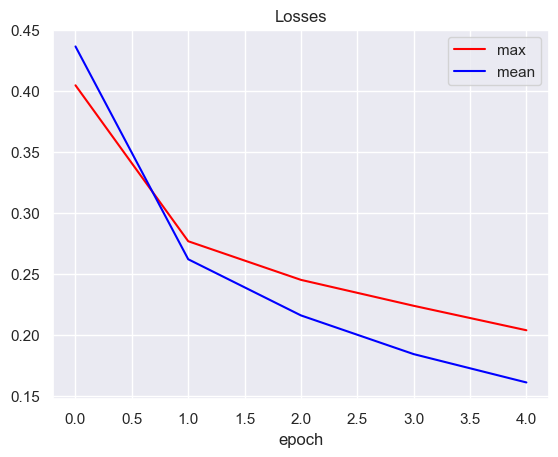

In [ ]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода max: 90.48
Лучшая accuracy для подхода mean: 90.52


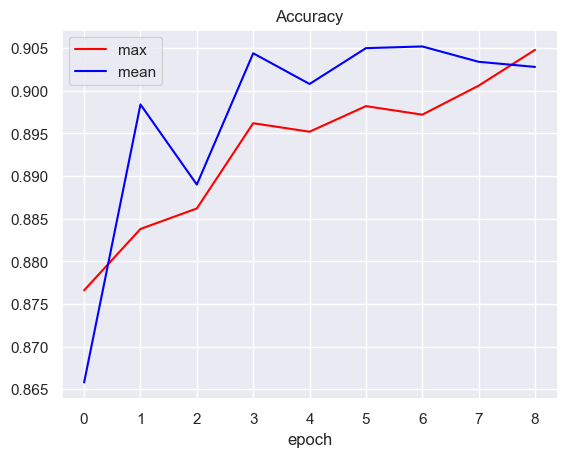

In [ ]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

Эксперимент 1: Замена RNN на GRU
GRU (Gated Recurrent Unit) обычно показывает лучшие результаты, чем ванильная RNN, благодаря механизму гейтов, который помогает справляться с проблемой исчезающего градиента.

In [ ]:
class CharLMGRU(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True)  # Замена RNN на GRU
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)
        
        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)
        
    
    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        

        output = output.max(dim=1)[0]
       
        
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]
        
        return prediction

In [ ]:
num_epoch = 5
eval_steps = len(train_dataloader) // 2

losses = []
acc = []

model = CharLMGRU(
    hidden_dim=256, vocab_size=len(vocab), num_classes=4).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

for epoch in range(num_epoch):
    epoch_losses = []
    model.train()
    for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
        optimizer.zero_grad()
        logits = model(batch['input_ids'])
        loss = criterion(logits, batch['label'])
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())
        if i % eval_steps == 0:
            model.eval()
            acc.append(evaluate(model))
            model.train()

    losses.append(sum(epoch_losses) / len(epoch_losses))

print(f"Final loss: {losses[-1]}, Final accuracy: {acc[-1]}")

Training epoch 4:: 100%|██████████| 3750/3750 [03:56<00:00, 15.89it/s]

Final loss: 0.09649336166437715, Final accuracy: 0.9114000201225281


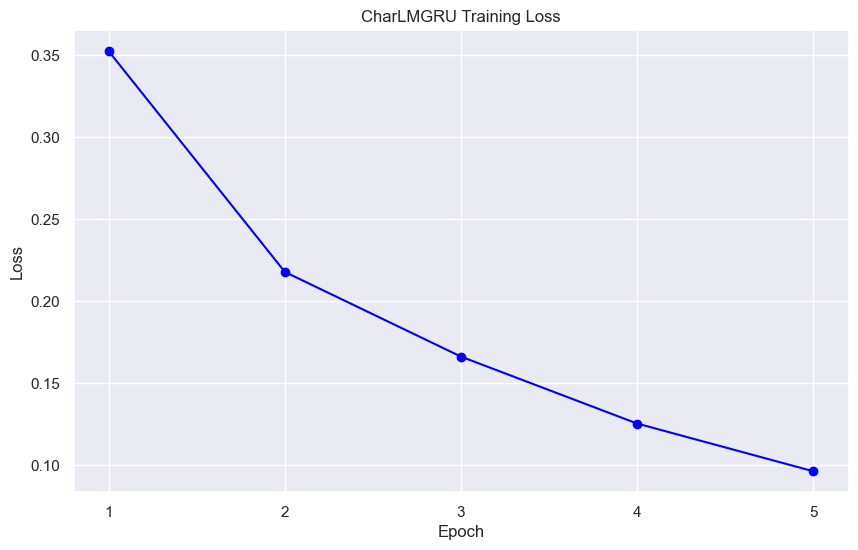

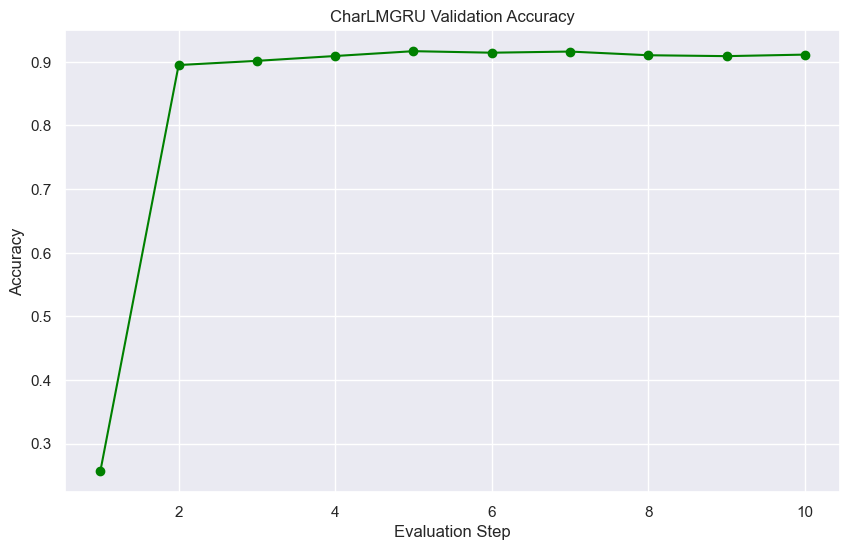

In [ ]:
def plot_loss(losses, title="Training Loss"):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(losses) + 1), losses, marker='o', linestyle='-', color='b')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.xticks(range(1, len(losses) + 1))
    plt.show()

# Построение графика точности (accuracy)
def plot_accuracy(accuracies, title="Validation Accuracy"):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(accuracies) + 1), accuracies, marker='o', linestyle='-', color='g')
    plt.title(title)
    plt.xlabel('Evaluation Step')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.show()

plot_loss(losses, "CharLMGRU Training Loss")
plot_accuracy(acc, "CharLMGRU Validation Accuracy")

LMGRU дает скор выше, чем CharLMGRU Final accuracy: 0.9114000201225281

Эксперимент 2: Только последнее скрытое состояние RNN. Это один из способов изменения архитектуры после применения RNN.

In [29]:
class CharLMLastHidden(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)
        
        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)
    
    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, hidden = self.rnn(embeddings)  # output: [batch_size, seq_len, hidden_dim], hidden: [1, batch_size, hidden_dim]
        
        # Используем последнее скрытое состояние вместо агрегации
        last_hidden = hidden.squeeze(0)  # [batch_size, hidden_dim]
        
        output = self.dropout(self.linear(self.non_lin(last_hidden)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]
        
        return prediction

In [30]:
num_epoch = 5
eval_steps = len(train_dataloader) // 2

losses = []
acc = []

model = CharLMLastHidden(
    hidden_dim=256, vocab_size=len(vocab), num_classes=4).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

for epoch in range(num_epoch):
    epoch_losses = []
    model.train()
    for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
        optimizer.zero_grad()
        logits = model(batch['input_ids'])
        loss = criterion(logits, batch['label'])
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())
        if i % eval_steps == 0:
            model.eval()
            acc.append(evaluate(model))
            model.train()

    losses.append(sum(epoch_losses) / len(epoch_losses))

print(f"Final loss: {losses[-1]}, Final accuracy: {acc[-1]}")

Training epoch 4:: 100%|██████████| 3750/3750 [02:03<00:00, 30.34it/s]

Final loss: 1.4015339224497476, Final accuracy: 0.24580000340938568


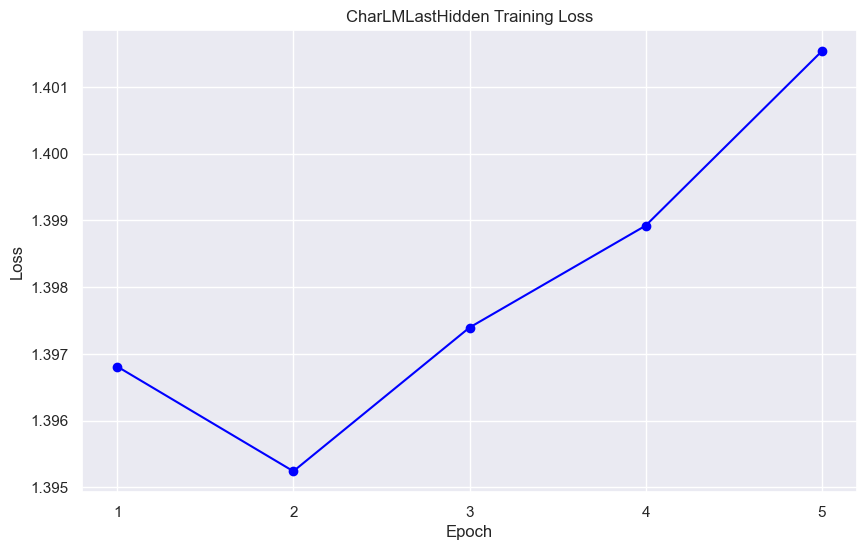

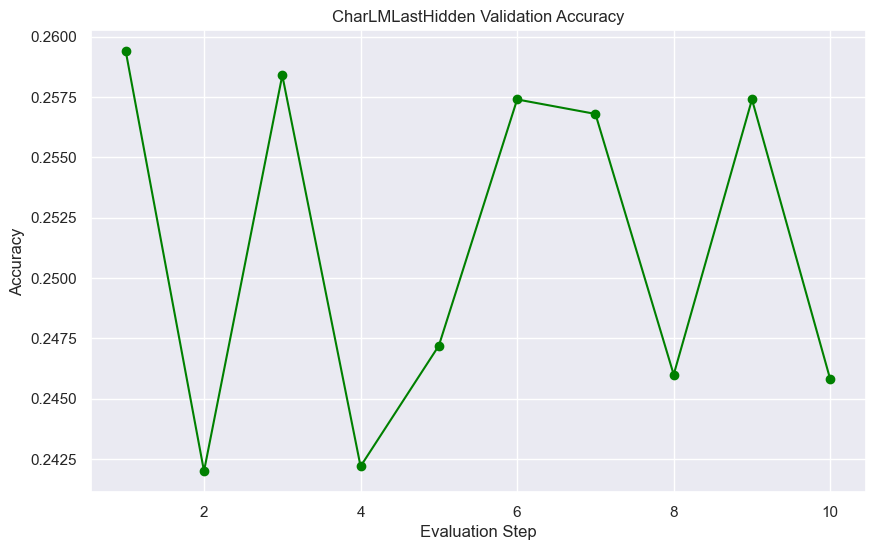

In [32]:
plot_loss(losses, "CharLMLastHidden Training Loss")
plot_accuracy(acc, "CharLMLastHidden Validation Accuracy")

Вывод: использовать LastHidden явно плохая идея

Эксперимент 3: Увеличение количества рекуррентных слоев
Добавим два слоя GRU вместо одного:

In [33]:
class CharLMMultiLayer(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max', num_layers: int = 2
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, num_layers=num_layers, batch_first=True)  # Добавлен параметр num_layers
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)
        
        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)
        
        self.aggregation_type = aggregation_type
    
    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        
        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")
        
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]
        
        return prediction

In [34]:
num_epoch = 5
eval_steps = len(train_dataloader) // 2


losses_type = {}
acc_type = {}

for aggregation_type in ['max', 'mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model = CharLMMultiLayer(
        hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model.eval()
                acc.append(evaluate(model))
                model.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))

    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

Starting training for max


Training epoch 4:: 100%|██████████| 3750/3750 [08:44<00:00,  7.15it/s]  


Starting training for mean


Training epoch 4:: 100%|██████████| 3750/3750 [06:40<00:00,  9.35it/s]


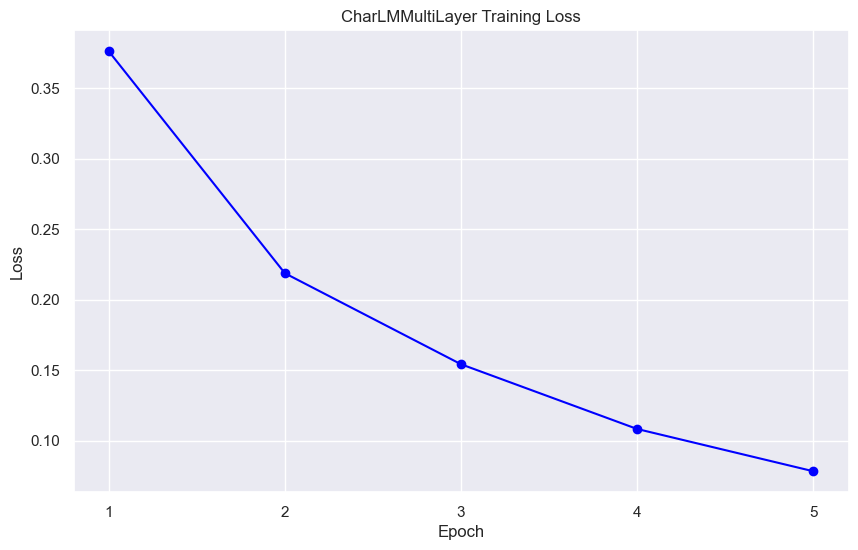

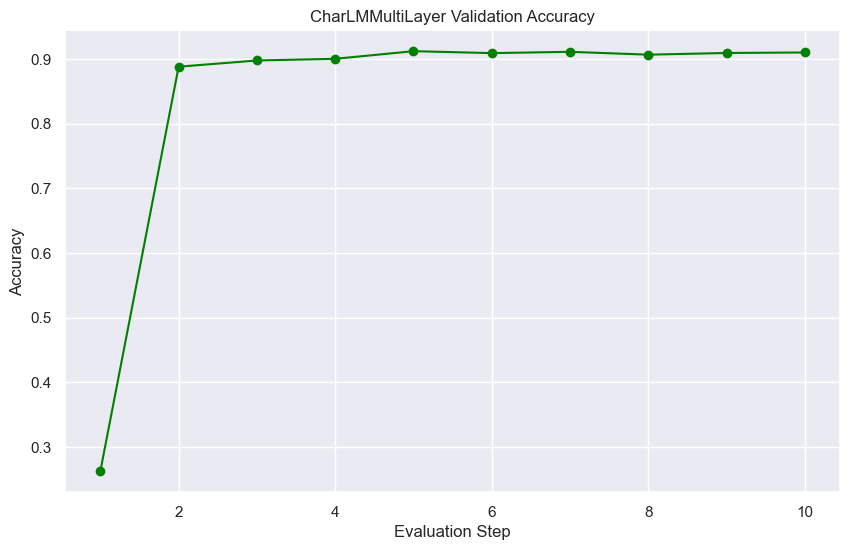

In [35]:
plot_loss(losses, "CharLMMultiLayer Training Loss")
plot_accuracy(acc, "CharLMMultiLayer Validation Accuracy")

In [36]:
print(f"Final loss: {losses[-1]}, Final accuracy: {acc[-1]}")

Final loss: 0.07829839064348489, Final accuracy: 0.9097999930381775


In [37]:
torch.save(model, 'full_model.pth')

# Сохранение только весов модели (state_dict)
torch.save(model.state_dict(), 'model_weights.pth')

In [40]:
def word_to_indices(text, vocab, word2ind=None):
    """
    Преобразует текст в последовательность индексов согласно словарю vocab
    
    Parameters:
    text (str): Входной текст для преобразования
    vocab (list): Словарь символов
    word2ind (dict, optional): Словарь индексов. Если None, будет создан
    
    Returns:
    list: Последовательность индексов
    """
    if word2ind is None:
        # Если словарь не предоставлен, создаем его из vocab
        word2ind = {char: i for i, char in enumerate(vocab)}
    
    # Преобразование текста в последовательность индексов
    indices = [word2ind.get(char, word2ind.get('<unk>', 0)) for char in text]
    
    return indices

In [41]:
def predict_text(model, text, vocab, device='cuda' if torch.cuda.is_available() else 'cpu'):
    # Предобработка текста (аналогично тому, что делается в вашем датасете)
    # Предполагаю, что у вас есть функции word_to_indices для превращения текста в индексы
    input_ids = word_to_indices(text, vocab)
    
    # Преобразование в тензор и добавление размерности батча
    input_tensor = torch.tensor([input_ids], dtype=torch.long).to(device)
    
    # Получение предсказания
    with torch.no_grad():  # Отключаем вычисление градиентов для ускорения
        logits = model(input_tensor)
        probabilities = torch.softmax(logits, dim=1)
        predicted_class = torch.argmax(logits, dim=1).item()
    
    return predicted_class, probabilities.cpu().numpy()[0]

In [103]:
# Пример использования для одного текста
text = "football play sports"
predicted_class, probabilities = predict_text(model, text, vocab)

print(f"Предсказанный класс: {predicted_class}")
print(f"Вероятности классов: {probabilities}")

# Для маппинга классов обратно в названия (если у вас есть словарь классов)
class_names = {0: "класс_1", 1: "класс_2", 2: "класс_3", 3: "класс_4"}
print(f"Предсказанная категория: {class_names[predicted_class]}")

Предсказанный класс: 2
Вероятности классов: [3.3107150e-04 2.2307005e-02 9.4827718e-01 2.9084740e-02]
Предсказанная категория: класс_3


In [43]:
# Просмотр первых нескольких примеров из тренировочного набора
for i in range(5):
    print(f"\nПример #{i}:")
    print(f"Текст: {dataset['train'][i]['text']}")
    print(f"Метка: {dataset['train'][i]['label']}")


Пример #0:
Текст: Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.
Метка: 2

Пример #1:
Текст: Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.
Метка: 2

Пример #2:
Текст: Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.
Метка: 2

Пример #3:
Текст: Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Satur

## Ход работы
Оценка за домашнее задание складывается из четырех частей:
### Запуск базовой модели с семинара на новом датасете (1 балл)
На семинаре мы создали модель, которая дает на нашей задаче довольно высокое качество. Ваша цель --- обучить ее и вычислить `score`, который затем можно будет использовать в качестве бейзлайна. 

В модели появится одно важное изменение: количество классов теперь равно не 2, а 4. Обратите на это внимание и найдите, что в коде создания модели нужно модифицировать, чтобы учесть это различие. 

### Проведение экспериментов по улучшению модели (2 балла за каждый эксперимент)
Чтобы улучшить качество базовой модели, можно попробовать различные идеи экспериментов. Каждый выполненный эксперимент будет оцениваться в 2 балла. Для получения полного балла за этот пункт вам необходимо выполнить по крайней мере 2 эксперимента. Не расстраивайтесь, если какой-то эксперимент не дал вам прироста к качеству: он все равно зачтется, если выполнен корректно. 

Вот несколько идей экспериментов:
* **Модель RNN**. Попробуйте другие нейросетевые модели --- LSTM и GRU. Мы советуем обратить внимание на [GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html), так как интерфейс этого класса ничем не отличается от обычной Vanilla RNN, которую мы использовали на семинаре.
* **Увеличение количества рекуррентных слоев модели**. Это можно сделать с помощью параметра `num_layers` в классе `nn.RNN`. В такой модели выходы первой RNN передаются в качестве входов второй RNN и так далее. 
* **Изменение архитектуры после применения RNN**. В базовой модели используется агрегация со всех эмбеддингов. Возможно, вы захотите конкатенировать результат агрегации и эмбеддинг с последнего токена.
* **Подбор гиперпараметров и обучение до сходимости**. Возможно, для получения более высокого качества просто необходимо увеличить количество эпох обучения нейросети, а также попробовать различные гиперпараметры: размер словаря, `dropout_rate`, `hidden_dim`.

Обратите внимание, что главное правило проведения экспериментов --- необходимо совершать одно архитектурное изменение в одном эксперименте. Если вы совершите несколько изменений, то будет неясно, какое именно из изменений дало прирост к качеству. 

### Получение высокого качества (3 балла)
В конце вашей работы вы должны указать, какая из моделей дала лучший результат, и вывести качество, которое дает лучшая модель, с помощью функции `evaluate`. Ваша модель будет оцениваться по метрике `accuracy` следующим образом:
* $accuracy < 0.9$ --- 0 баллов;
* $0.9 \leqslant accuracy < 0.91$ --- 1 балл;
* $0.91 \leqslant accuracy < 0.915$ --- 2 балла;
* $0.915 \leqslant accuracy$ --- 3 балла.

### Оформление отчета (2 балла)
В конце работы подробно опишите все проведенные эксперименты. 
* Укажите, какие из экспериментов принесли улучшение, а какие --- нет. 
* Проанализируйте графики сходимости моделей в проведенных экспериментах. Являются ли колебания качества обученных моделей существенными в зависимости от эпохи обучения, или же сходимость стабильная? 
* Укажите, какая модель получилась оптимальной.

Желаем удачи!

**Проведенные эксперименты**

**Эксперимент 1:** Замена RNN на GRU

Описание: В этом эксперименте базовая RNN была заменена на GRU (Gated Recurrent Unit), которая лучше справляется с проблемой исчезающего градиента благодаря механизму гейтов.

Результаты: Использование GRU вместо стандартной RNN привело к существенному улучшению результатов. CharLMGRU показала себя как наиболее оптимальная модель среди всех протестированных. Она быстрее сходилась и достигала более высокой точности.

**Эксперимент  2:** Использование только последнего скрытого состояния

Описание: В этом эксперименте вместо агрегации (max или mean) по всем выходным векторам RNN использовалось только последнее скрытое состояние.

Результаты: Этот подход показал себя крайне неэффективным. Модель, использующая только последний выходной вектор базовой RNN, демонстрировала значительно худшие результаты по сравнению с базовой моделью и другими модификациями. Это говорит о том, что для данной задачи важна информация со всех временных шагов, а не только с последнего.

**Эксперимент 3:**  Увеличение количества рекуррентных слоев

Описание: В этом эксперименте было увеличено количество рекуррентных слоев в модели с одного до двух, чтобы повысить способность модели к выделению более сложных зависимостей в данных.

Результаты: RNN с двумя скрытыми слоями работала значительно хуже, чем базовая модель с одним слоем. 